## STAT 628 Module 2

# Body Fat Prediction
Authors (Thurs_Group3): Zheng Ni, Jingpeng Weizhou, Zifeng Wang, Ke Chen

## 1. Introduction

Body fat percentage is a crucial index for describing health condition, which is a measurement of obesity. 

In fact, many reserachers have proposed  various accurate way to calculate body fat percentage, while these methods always require costly measurement. In hence, we would like to construct a simple but also precise "rule of thumb" method to predict body fat percentage of males using available clinical measurements.

In this project, we try with multiple linear regression models with different subset of features and finally choose the best model with highest accuracy and robustness.


## 2. Data Description

The dataset contains 252 men with measurements of their percentage of body fat and various body circumference measurements. Overall, the response variable is **BODYFAT** and there are 16 explained variables including **AGE,WEIGHT,HEIGHT**, etc. The following table shows the structure of our dataset.

In [1]:
setwd('E:/stat628')
data = read.csv('BodyFat.csv',header = TRUE)
data[1:5,]

IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
1,12.6,1.0708,23,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
2,6.9,1.0853,22,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
3,24.6,1.0414,22,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
4,10.9,1.0751,26,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
5,27.8,1.0340,24,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Based on previous research, we know that **DENSITY** is almost perfectly correlated with **BODYFAT**, which can also be captured by the formula, **BODYFAT = 495/DENSITY - 450**. Consequently, we cannot view **DENSITY** as a reliable variable.

The following table are the explained variables we would use in the our model.

|**AGE**|**WEIGHT**|**HEIGHT**|**ADIPOSITY**|**NECK**|**CHEST**|**ABDOMEN**|**HIP**|**THIHG**|**KNEE**|**ANKLE**|**BICEPS**|**FOREARM**|**WRIST**|
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|years|lbs|inches|bmi|cm|cm|cm|cm|cm|cm|cm|cm|cm|cm|

## 3. Data Preprocessing

Before we go into modeling part, we have to check whether there are missing values and outliers in our model. Based on the code below, we find there is no missing values in our dataset, so we don't need to use imputation method. As for the outliers, we would check the boxplot first to see if there are some data beyond 75% quantile.

From the boxplots below, we find some people have extremely low height, some have extremely high weight and bodyfat and even one man has 0 bodyfat which are beyond the possible range. So we think these records are outliers.

Number of missing values: 0 
Outliers: 42 39 216 41 31 86 159 175 226

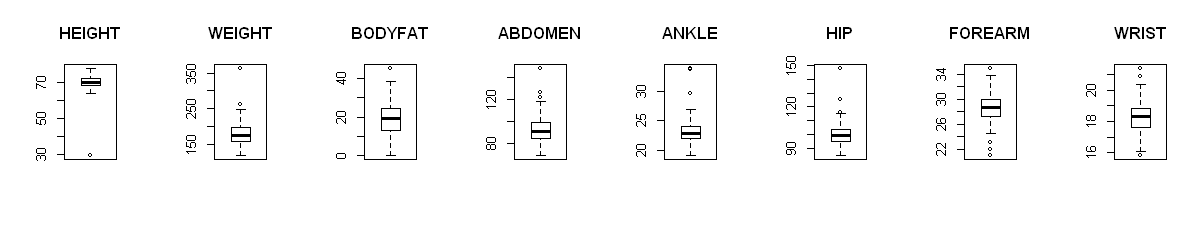

In [4]:
options(repr.plot.width=10, repr.plot.height=2)
cat('Number of missing values:',sum(is.na(data)),'\n')
par(mfrow=c(1,8))
boxplot(data$HEIGHT,main='HEIGHT');boxplot(data$WEIGHT,main='WEIGHT') 
boxplot(data$BODYFAT,main='BODYFAT');boxplot(data$ABDOMEN,main='ABDOMEN')
boxplot(data$ANKLE,main='ANKLE');boxplot(data$HIP,main='HIP')
boxplot(data$FOREARM,main='FOREARM');boxplot(data$WRIST,main='WRIST')
cat('Outliers:',unique(c(which(data$HEIGHT<40),which(data$WEIGHT>300),which(data$BODYFAT>40),
                 which(data$ABDOMEN>120),which(data$ANKLE>30),which(data$HIP>120),which(data$FOREARM>34),
                  which(data$FOREARM<22),which(data$WRIST<16))))

After detecting the outliers, we try with the following methods to deal with the outliers.
1. Fisrtly, we use some BMI function(**BMI(ADIPOSITY) = WEIGHT/(HEIGHT^2) * 703**) and the relation between BODYFAT and DENSITY proposed by researchers (**BODYFAT = 495/DENSITY - 450**). These functions can help us to compute the value of outliers.
2. Secondly, we utilize regression imputation method. We regress the outlier feature on other related features and get the estimate of the real value of the outliers.
3. Finally, for those data which are consistent with the function above, they might not due to inaccurate measurement. They may be some extreme values which are far from other data, we mainly choose to drop these records in order to get more precise analysis.

In [7]:
# BY BMI FUNCTION
data[,'HEIGHT'][42] = sqrt(205*703/29.9)
data[,'ADIPOSITY'][221] = 153.25/70.50^2*703
# Regression IMPUTATION
data[,'WRIST'][226] = 6.5+0.26*data[,'ANKLE'][226]+0.18*data[,'KNEE'][226]+0.02*data[,'AGE'][226] # lm(WRIST~ANKLE+KNEE+AGE)
data[,'ANKLE'][31] = 3.1+0.56*data[,'WRIST'][31]+0.28*data[,'KNEE'][31]-0.02*data[,'AGE'][31] # lm(ANKLE~WRIST+KNEE+AGE))
data[,'ANKLE'][86] = 3.1+0.56*data[,'WRIST'][86]+0.28*data[,'KNEE'][86]-0.02*data[,'AGE'][86] # lm(ANKLE~WRIST+KNEE+AGE)
# DROP OUTLIERS
data = data[-c(39,41,216),]

## 4. StepWise by AIC

Now, we can use the cleaned data to do regression and select variable we need. We use AIC as the criterion to do forward and backward regression.For forward regression:

In [8]:
library('MASS')
X <- data[,4:17] 
Y <- data$BODYFAT
biggest <- formula(lm(Y~.,X))
min_model <- lm(Y~1,data = X)
forward_model <- step(min_model,direction = 'forward',scope = biggest,trace = 0)
summary(forward_model)


Call:
lm(formula = Y ~ ABDOMEN + WEIGHT + WRIST + ADIPOSITY + AGE + 
    THIGH + NECK + FOREARM, data = X)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.7428 -2.8534 -0.1652  2.7724  9.0224 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -26.53262    8.70380  -3.048  0.00256 ** 
ABDOMEN       0.75425    0.07946   9.492  < 2e-16 ***
WEIGHT       -0.09199    0.03243  -2.836  0.00495 ** 
WRIST        -1.31379    0.46940  -2.799  0.00555 ** 
ADIPOSITY     0.31972    0.21985   1.454  0.14717    
AGE           0.06481    0.02868   2.260  0.02473 *  
THIGH         0.18792    0.11142   1.687  0.09299 .  
NECK         -0.37182    0.20556  -1.809  0.07174 .  
FOREARM       0.28155    0.18200   1.547  0.12318    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.919 on 240 degrees of freedom
Multiple R-squared:  0.736,	Adjusted R-squared:  0.7272 
F-statistic: 83.63 on 8 and 240 DF,  p-value: < 2.2e-16


For backward regerssion

In [9]:

backward_model <- step(lm(Y~.,data = X),direction = 'backward',trace = 0)
summary(backward_model)



Call:
lm(formula = Y ~ AGE + ADIPOSITY + NECK + CHEST + ABDOMEN + HIP + 
    THIGH + WRIST, data = X)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6903 -2.8165 -0.2842  2.9056  9.8680 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.27550    6.98750   0.469 0.639663    
AGE          0.07031    0.02729   2.576 0.010593 *  
ADIPOSITY    0.57554    0.24202   2.378 0.018189 *  
NECK        -0.40417    0.19852  -2.036 0.042855 *  
CHEST       -0.16522    0.09045  -1.827 0.068992 .  
ABDOMEN      0.75934    0.08074   9.405  < 2e-16 ***
HIP         -0.24628    0.11498  -2.142 0.033206 *  
THIGH        0.18965    0.12730   1.490 0.137583    
WRIST       -1.47906    0.43104  -3.431 0.000707 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.922 on 240 degrees of freedom
Multiple R-squared:  0.7355,	Adjusted R-squared:  0.7267 
F-statistic: 83.42 on 8 and 240 DF,  p-value: < 2.2e-16


## Compare model

For these two stepwise regression above, we can see the results are same: variables ABDOMEN is the most significant and the main variable we should select. Then, we consider variable WRIST and WEIGHT. We can developt two models that one caontains WEIGHT while another contains WRIST. Comparing the R- squared value, we can decide add which one variable to model.

In [14]:
select_model_1 <- lm(Y ~ X$ABDOMEN + X$WEIGHT)
select_model_2 <- lm(Y ~ X$ABDOMEN + X$WRIST)
summary(select_model_1)
summary(select_model_2)


Call:
lm(formula = Y ~ X$ABDOMEN + X$WEIGHT)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.0723  -2.9076  -0.1245   2.9423   9.9560 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -43.10621    2.53404 -17.011  < 2e-16 ***
X$ABDOMEN     0.90050    0.05307  16.967  < 2e-16 ***
X$WEIGHT     -0.11871    0.01974  -6.015 6.47e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.055 on 246 degrees of freedom
Multiple R-squared:  0.7103,	Adjusted R-squared:  0.7079 
F-statistic: 301.5 on 2 and 246 DF,  p-value: < 2.2e-16



Call:
lm(formula = Y ~ X$ABDOMEN + X$WRIST)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.4007 -2.8544 -0.1714  2.9384 10.3270 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -12.25598    5.44866  -2.249   0.0254 *  
X$ABDOMEN     0.72322    0.03233  22.371  < 2e-16 ***
X$WRIST      -1.95556    0.36091  -5.418 1.43e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.105 on 246 degrees of freedom
Multiple R-squared:  0.7031,	Adjusted R-squared:  0.7007 
F-statistic: 291.3 on 2 and 246 DF,  p-value: < 2.2e-16


According to the model comparing above, we find the R sqaure of model 1 is bigger than model 2, we can select the model 1 as the final model.